In [1]:
import torch
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
from DNN_module import Net

# CPU
torch.set_default_device("cpu")

%run ../../NCoinDP_functions.ipynb

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# Number of data points
#S = 500

# time inteval

delta = 1/12

#n = int(S/delta)
n = 5000

# Observation time
obtime = np.arange(0,n+1)/n * n * delta
print(len(obtime))

5001


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev)

2.1.2+cu121
True
NVIDIA A10


In [16]:
kappa_11_range = [0.1, 3]
kappa_21_range = [0.1, 3]
kappa_22_range = [0.1, 3]

beta_1_range = [-1, 1]
beta_2_range = [-1, 1]

sigma2_1_range = [0.1, 0.5]
sigma2_2_range = [0.1, 0.5]

lambda_1_range = [0.01, 1]
lambda_2_range = [0.01, 1]

mu_1_range = [0.1,1.5]
mu_2_range = [0.1,1.5]

output_range = [kappa_11_range, kappa_21_range, kappa_22_range, beta_1_range, beta_2_range,
               sigma2_1_range, sigma2_2_range, lambda_1_range, lambda_2_range, mu_1_range, mu_2_range]

In [5]:
# Data import
torch.set_default_device(device)

X_raw = []
output_raw = []
for j in [0, 1]:
    sim_path = "../../../depot_hyun/hyun/BOUJ/BOUJ_sim" + str(j) + "_" + str(n)+ ".pt"
    [tmp_X, tmp_y] = torch.load(sim_path)
    X_raw.append(tmp_X)
    output_raw.append(tmp_y)

X_raw = torch.cat(X_raw, dim = 0)
output = torch.cat(output_raw, dim = 0)
X_raw = X_raw.to("cpu")

c_tmp = torch.quantile(X_raw, torch.tensor([.0001,.9999], device = "cpu"), 0)
a = torch.reshape(c_tmp[0], (1, c_tmp.size()[1]))
b = torch.reshape(c_tmp[1], (1, c_tmp.size()[1]))

X = torch.clone((X_raw - a) / (b - a))

X = X.to(device)
output = output.to(device)

L = X.size()[0]
Lval = 40000
Ltest = 10000

X_train = X[range(0,L-Lval-Ltest),:]
y_train = output[range(0,L-Lval-Ltest),:]

X_val = X[range(L-Lval-Ltest,L-Ltest),:]
y_val = output[range(L-Lval-Ltest,L-Ltest),:]

X_test = X[range(L-Ltest,L),:]
y_test = output[range(L-Ltest,L),:]

print(X_train.size(), X_val.size(),X_test.size())

# Define the input and output dimensions
D_in, H, H2, H3, D_out = X_train.size()[1], 512, 512, 512, y_train.size()[1]

# Create an instance of the Net class with specified dimensions
torch.manual_seed(2725)

# import net
net = Net(D_in, D_out, H = H, H2 = H2, H3 = H3)
model_save_name = 'BOUJ_nets/BOUJ_infer.pt'
path = F"./{model_save_name}"

torch.Size([450000, 130]) torch.Size([40000, 130]) torch.Size([10000, 130])


In [6]:
for i in range(X.size()[1]):
    print(i, torch.max(X[:,i]), a[0,i], b[0,i])

0 tensor(1.5946, device='cuda:0') tensor(-0.9888) tensor(55.5436)
1 tensor(1.5944, device='cuda:0') tensor(-0.9889) tensor(55.5581)
2 tensor(2.3409, device='cuda:0') tensor(0.0003) tensor(6.8645)
3 tensor(2.3278, device='cuda:0') tensor(0.0004) tensor(6.9502)
4 tensor(2.3275, device='cuda:0') tensor(0.0004) tensor(6.9434)
5 tensor(1.1454, device='cuda:0') tensor(-274.8458) tensor(49.3731)
6 tensor(1.1455, device='cuda:0') tensor(-274.8793) tensor(49.3799)
7 tensor(4.9256, device='cuda:0') tensor(0.0004) tensor(143.4852)
8 tensor(4.9283, device='cuda:0') tensor(0.0005) tensor(143.5474)
9 tensor(4.9218, device='cuda:0') tensor(0.0005) tensor(143.4885)
10 tensor(1.0023, device='cuda:0') tensor(-15.1208) tensor(0.0121)
11 tensor(1.0023, device='cuda:0') tensor(-15.0037) tensor(0.0133)
12 tensor(1.0022, device='cuda:0') tensor(-15.2683) tensor(0.0116)
13 tensor(1.0023, device='cuda:0') tensor(-15.0996) tensor(0.0120)
14 tensor(1.1216, device='cuda:0') tensor(0.0732) tensor(1.4761)
15 tensor

In [7]:
import torch
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
# N is batch size; 
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
# L = 1000 -> H = 64

# Define the batch size
BATCH_SIZE = 64


# Use torch.utils.data to create a DataLoader 
# that will take care of creating batches 
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
dataset_size = len(dataloader.dataset)

In [8]:
def weighted_mse_loss(input, target, weight):
        return (weight * (input - target) ** 2).sum()
out_range = [torch.quantile(output,.01, 0).detach().cpu().numpy(), torch.quantile(output,.99, 0).detach().cpu().numpy()]
weight_1 = torch.tensor(1/(out_range[1] - out_range[0])**2)
print(weight_1)

tensor([0.1239, 0.1238, 0.1238, 0.2604, 0.2603, 6.5116, 6.5048, 1.0627, 1.0623,
        0.5312, 0.5313], device='cuda:0')


In [10]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

train_error_plt = []
val_error_plt = []

torch.manual_seed(2000)
N_EPOCHS = 350
# Loop over epochs
for epoch in range(N_EPOCHS):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        y_batch_pred = net(x_batch)
        #loss = loss_fn(y_batch_pred, y_batch)
        loss = weighted_mse_loss(y_batch, y_batch_pred, weight_1)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 ==0 and id_batch % 1000 == 0:
            loss, current = loss.item(), (id_batch + 1)* len(x_batch)
            print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")

    with torch.no_grad():
           net.eval()
           theta_pred_train = net(X_train)
           #train_loss = loss_fn(theta_pred_train,Y_train) / L_train
           train_loss = weighted_mse_loss(y_train, theta_pred_train, weight_1) /( L - Lval - Ltest )
           
           train_error_plt = np.append(train_error_plt, train_loss.to("cpu"))

           theta_pred_val = net(X_val)
           #val_loss = loss_fn(Y_val, theta_pred_val) / L_val
           val_loss = weighted_mse_loss(y_val, theta_pred_val, weight_1) / Lval
           
           val_error_plt = np.append(val_error_plt, val_loss.to("cpu"))

    if epoch % 10 ==0:
        print(f"Epoch {epoch + 1}\n-------------------------------")
        print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")
        #print("learning rate: ", learning_rate, ", sim: ", sim)

    ## Choose Best Model
    if val_error_plt[epoch] == np.min(val_error_plt):
         best=epoch
         torch.save(net.state_dict(), path)

    if epoch % 100 ==99:
        net.load_state_dict(torch.load(path))
        learning_rate = max(learning_rate * 1e-1, 1e-9)

train_loss: 6.889273  [   64/450000]
train_loss: 0.536200  [64064/450000]
train_loss: 0.433997  [128064/450000]
train_loss: 0.407576  [192064/450000]
train_loss: 0.422122  [256064/450000]
train_loss: 0.326205  [320064/450000]
train_loss: 0.292529  [384064/450000]
train_loss: 0.272945  [448064/450000]
Epoch 1
-------------------------------
train_loss 0.353207 val_loss 0.352343
train_loss: 0.190095  [   64/450000]
train_loss: 0.116908  [64064/450000]
train_loss: 0.139455  [128064/450000]
train_loss: 0.149677  [192064/450000]
train_loss: 0.154848  [256064/450000]
train_loss: 0.131753  [320064/450000]
train_loss: 0.129286  [384064/450000]
train_loss: 0.124656  [448064/450000]
Epoch 11
-------------------------------
train_loss 0.120419 val_loss 0.123313
train_loss: 0.152262  [   64/450000]
train_loss: 0.133415  [64064/450000]
train_loss: 0.099903  [128064/450000]
train_loss: 0.101863  [192064/450000]
train_loss: 0.117745  [256064/450000]
train_loss: 0.122508  [320064/450000]
train_loss: 0

train_loss: 0.094989  [320064/450000]
train_loss: 0.073796  [384064/450000]
train_loss: 0.083449  [448064/450000]
Epoch 211
-------------------------------
train_loss 0.086089 val_loss 0.100505
train_loss: 0.097534  [   64/450000]
train_loss: 0.070634  [64064/450000]
train_loss: 0.088375  [128064/450000]
train_loss: 0.097294  [192064/450000]
train_loss: 0.082841  [256064/450000]
train_loss: 0.102340  [320064/450000]
train_loss: 0.102867  [384064/450000]
train_loss: 0.085681  [448064/450000]
Epoch 221
-------------------------------
train_loss 0.085862 val_loss 0.102888
train_loss: 0.070579  [   64/450000]
train_loss: 0.091242  [64064/450000]
train_loss: 0.081681  [128064/450000]
train_loss: 0.086377  [192064/450000]
train_loss: 0.093538  [256064/450000]
train_loss: 0.087652  [320064/450000]
train_loss: 0.081144  [384064/450000]
train_loss: 0.087008  [448064/450000]
Epoch 231
-------------------------------
train_loss 0.081966 val_loss 0.101746
train_loss: 0.096346  [   64/450000]
train

In [20]:
print(np.min(val_error_plt))

0.0971958339214325


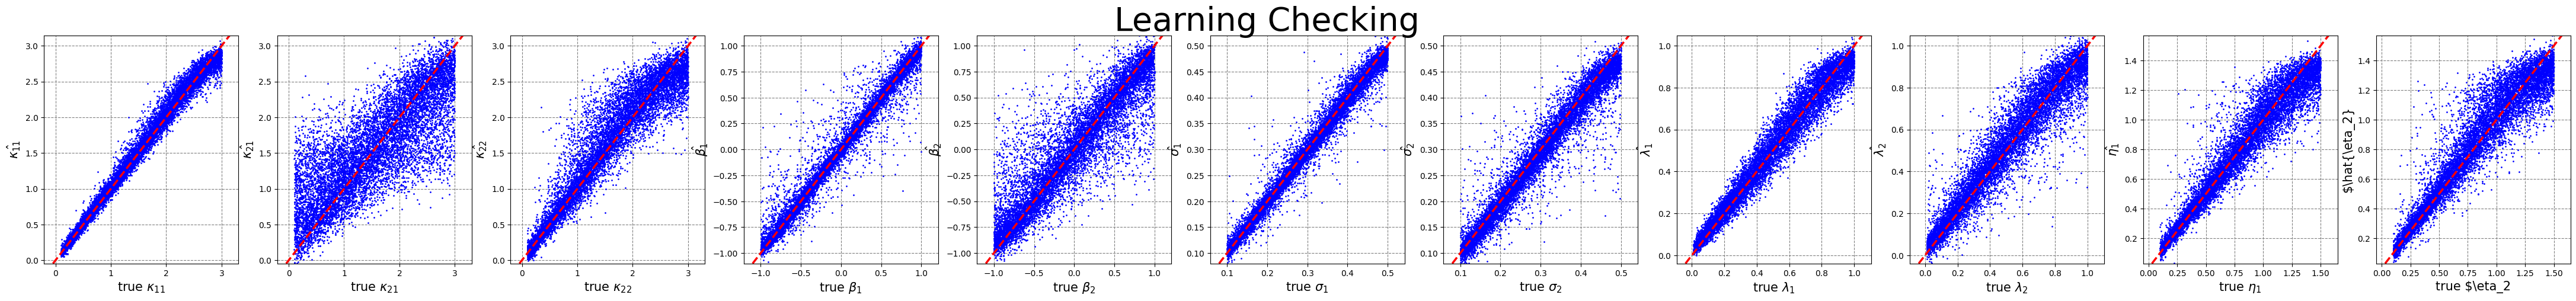

In [9]:
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")


true_name = [r'true $\kappa_{11}$', r'true $\kappa_{21}$', r'true $\kappa_{22}$', 
             r'true $\beta_1$', r'true $\beta_2$',
             r'true $\sigma_1$', r'true $\sigma_2$',
             r'true $\lambda_1$', r'true $\lambda_2$',
             r'true $\eta_1$', r'true $\eta_2']
esti_name = [r'$\hat{\kappa_{11}}$', r'$\hat{\kappa_{21}}$', r'$\hat{\kappa_{22}}$', 
             r'$\hat{\beta_{1}}$', r'$\hat{\beta_{2}}$',
             r'$\hat{\sigma_{1}}$', r'$\hat{\sigma_{2}}$',
             r'$\hat{\lambda_{1}}$',r'$\hat{\lambda_{2}}$',
             r'$\hat{\eta_1}$', r'$\hat{\eta_2}']

with torch.no_grad():
    net.eval()
    tmp = net(X_test)

## Plot for model checking
lim = [torch.min(output,0).values.detach().cpu().numpy(), torch.max(output,0).values.detach().cpu().numpy()]
lim = np.array(list(lim))
lim2 = lim[1] - lim[0]
lim = [lim[0] - lim2 * 1/20, lim[1] + lim2 * 1/20 ]
lim = np.array(lim)
fig, axes = plt.subplots(1, D_out, figsize=(5 * D_out,5))
fig.suptitle('Learning Checking', fontsize = 40)

for i in range(D_out):
    lim1 = lim[:,i]
    tmp1 = tmp[:,i].detach().cpu().numpy().tolist() 
    axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim1[0], lim1[1], 1000), np.linspace(lim1[0], lim1[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim(lim1)

In [10]:
torch.set_default_device("cpu")
torch.manual_seed(2726)

param  = torch.tensor([2,   0.8,  1.7, -0.5,  0.5, 0.15,  0.4,  0.8, 0.15,    1,  0.5])
param1 = torch.tensor([1.5, 2.3,  0.8,  0.5,    0,  0.4, 0.15,  0.5,  0.5,  0.5, 0.25])
param2 = torch.tensor([0.8, 1.5,  2.2,    0,  -0.5,  0.3,  0.3, 0.15,  0.8, 0.25,    1])

sim_test = 1
y01 = torch.ones(sim_test) * 0
y02 = torch.ones(sim_test) * 0

torch.manual_seed(1)
    
yL = BOUJ_simul_sample(obtime, 20, y01, y02, param[0]*torch.ones(sim_test), param[1]*torch.ones(sim_test), 
                           param[2]*torch.ones(sim_test), param[3]*torch.ones(sim_test), 
                           param[4]*torch.ones(sim_test), param[5] ** (1/2) * torch.ones(sim_test), 
                           param[6] ** (1/2) * torch.ones(sim_test), 
                           param[7]*torch.ones(sim_test), param[8]*torch.ones(sim_test), 
                           param[9]*torch.ones(sim_test), param[10]*torch.ones(sim_test))
x_test = BOUJ_summary(yL)
    
    
yL1 = BOUJ_simul_sample(obtime, 20, y01, y02, param1[0]*torch.ones(sim_test), param1[1]*torch.ones(sim_test), 
                           param1[2]*torch.ones(sim_test), param1[3]*torch.ones(sim_test), 
                           param1[4]*torch.ones(sim_test), param1[5] ** (1/2) * torch.ones(sim_test), 
                           param1[6] ** (1/2) * torch.ones(sim_test), 
                           param1[7]*torch.ones(sim_test), param1[8]*torch.ones(sim_test), 
                           param1[9]*torch.ones(sim_test), param1[10]*torch.ones(sim_test))
x_test1 = BOUJ_summary(yL1)
    
    
yL2 = BOUJ_simul_sample(obtime, 20, y01, y02, param2[0]*torch.ones(sim_test), param2[1]*torch.ones(sim_test), 
                           param2[2]*torch.ones(sim_test), param2[3]*torch.ones(sim_test), 
                           param2[4]*torch.ones(sim_test), param2[5] ** (1/2) * torch.ones(sim_test), 
                           param2[6] ** (1/2) * torch.ones(sim_test), 
                           param2[7]*torch.ones(sim_test), param2[8]*torch.ones(sim_test), 
                           param2[9]*torch.ones(sim_test), param2[10]*torch.ones(sim_test))
x_test2 = BOUJ_summary(yL2)
    
print(x_test.size())
print(torch.mean(net(x_test),0))

torch.Size([1, 130])
tensor([  8.1354,  29.4143,  16.6958,  -0.6023, -10.6831,   0.7252,   0.3674,
          0.6144,   2.9062,   0.4908,  -5.9246], grad_fn=<MeanBackward1>)


In [11]:
x_test_scale = torch.clone((x_test - a ) / (b - a))
x_test1_scale = torch.clone((x_test1 - a ) / (b - a))
x_test2_scale = torch.clone((x_test2 - a ) / (b - a))

print(torch.mean(net(x_test_scale),0))
print(torch.mean(net(x_test1_scale),0))
print(torch.mean(net(x_test2_scale),0))


tensor([ 1.9899,  1.0129,  1.9701, -0.5422,  0.6012,  0.1481,  0.3887,  0.9115,
         0.1436,  1.0032,  0.4863], grad_fn=<MeanBackward1>)
tensor([1.4273, 2.2100, 0.8973, 0.4886, 0.0277, 0.3968, 0.1308, 0.5727, 0.4756,
        0.5276, 0.1860], grad_fn=<MeanBackward1>)
tensor([ 0.8114,  1.7098,  2.4695, -0.0131, -0.4529,  0.3057,  0.3130,  0.1957,
         0.7916,  0.2502,  0.9597], grad_fn=<MeanBackward1>)


In [12]:
x0 = torch.reshape(x_test_scale, (1,x_test_scale.size()[1]))
x1 = torch.reshape(x_test1_scale, (1,x_test_scale.size()[1]))
x2 = torch.reshape(x_test2_scale, (1,x_test_scale.size()[1]))

In [13]:
net.load_state_dict(torch.load(path))
net = net.to("cpu")

In [14]:
path_cal = "../../../depot_hyun/hyun/BOUJ/BOUJ_sim"
    
X_cal = []
y_cal = []

sim_num = []
for j in range(2, 30):
    sim_num.append(j)

for j in sim_num:
    path_tmp = path_cal+str(j)+ "_" + str(n)+ ".pt"
    [tmp_X, tmp_y] = torch.load(path_tmp)
    X_cal.append(tmp_X)
    y_cal.append(tmp_y)

X_cal = torch.cat(X_cal, dim = 0)
y_cal = torch.cat(y_cal, dim = 0)

X_cal = torch.clone((X_cal - a) / (b - a))

In [15]:
results_00 = conf_inf_sd(x0, X_cal, y_cal, net, .03)
results_01 = conf_inf_sd(x0, X_cal, y_cal, net, .04)
results_02 = conf_inf_sd(x0, X_cal, y_cal, net, .05)
torch.save([results_00, results_01, results_02], "BOUJ_calibrate/BOUJ_infer_0.pt")

train_loss: 0.732092  [   64/73500]
train_loss: 0.734348  [ 6464/73500]
train_loss: 0.704313  [12864/73500]
train_loss: 0.661319  [19264/73500]
train_loss: 0.609279  [25664/73500]
train_loss: 0.644536  [32064/73500]
train_loss: 0.571659  [38464/73500]
train_loss: 0.551302  [44864/73500]
train_loss: 0.510116  [51264/73500]
train_loss: 0.483741  [57664/73500]
train_loss: 0.457227  [64064/73500]
train_loss: 0.406302  [70464/73500]
Epoch 1
-------------------------------
train_loss 0.427211 val_loss 0.428846
Epoch 31
-------------------------------
train_loss 0.071100 val_loss 0.072107
train_loss: 0.063546  [   64/73500]
train_loss: 0.075800  [ 6464/73500]
train_loss: 0.070194  [12864/73500]
train_loss: 0.068487  [19264/73500]
train_loss: 0.073171  [25664/73500]
train_loss: 0.077455  [32064/73500]
train_loss: 0.068521  [38464/73500]
train_loss: 0.061899  [44864/73500]
train_loss: 0.076662  [51264/73500]
train_loss: 0.076393  [57664/73500]
train_loss: 0.069350  [64064/73500]
train_loss: 0.0

Epoch 91
-------------------------------
train_loss 0.063029 val_loss 0.065576
train_loss: 0.067156  [   64/122499]
train_loss: 0.053496  [ 6464/122499]
train_loss: 0.071694  [12864/122499]
train_loss: 0.079025  [19264/122499]
train_loss: 0.067584  [25664/122499]
train_loss: 0.062224  [32064/122499]
train_loss: 0.076763  [38464/122499]
train_loss: 0.052199  [44864/122499]
train_loss: 0.087760  [51264/122499]
train_loss: 0.057172  [57664/122499]
train_loss: 0.059612  [64064/122499]
train_loss: 0.061489  [70464/122499]
train_loss: 0.051833  [76864/122499]
train_loss: 0.066336  [83264/122499]
train_loss: 0.064627  [89664/122499]
train_loss: 0.070651  [96064/122499]
train_loss: 0.070396  [102464/122499]
train_loss: 0.059820  [108864/122499]
train_loss: 0.058444  [115264/122499]
train_loss: 0.071434  [121664/122499]
Epoch 121
-------------------------------
train_loss 0.062361 val_loss 0.065700
train_loss: 0.066492  [   64/122499]
train_loss: 0.056213  [ 6464/122499]
train_loss: 0.064434  [

In [ ]:
net.eval()

results_10 = conf_inf_sd(x1, X_cal, y_cal, net, .03)
results_11 = conf_inf_sd(x1, X_cal, y_cal, net, .04)
results_12 = conf_inf_sd(x1, X_cal, y_cal, net, .05)
torch.save([results_10, results_11, results_12], "BOUJ_calibrate/BOUJ_infer_1.pt")

train_loss: 0.828928  [   64/73500]
train_loss: 0.816385  [ 6464/73500]
train_loss: 0.767807  [12864/73500]
train_loss: 0.694562  [19264/73500]
train_loss: 0.634161  [25664/73500]
train_loss: 0.666290  [32064/73500]
train_loss: 0.595344  [38464/73500]
train_loss: 0.563658  [44864/73500]
train_loss: 0.538635  [51264/73500]
train_loss: 0.506730  [57664/73500]
train_loss: 0.450329  [64064/73500]
train_loss: 0.459681  [70464/73500]
Epoch 1
-------------------------------
train_loss 0.445550 val_loss 0.446332
Epoch 31
-------------------------------
train_loss 0.077943 val_loss 0.079637
train_loss: 0.087958  [   64/73500]
train_loss: 0.072224  [ 6464/73500]
train_loss: 0.084592  [12864/73500]
train_loss: 0.068390  [19264/73500]
train_loss: 0.083029  [25664/73500]
train_loss: 0.091625  [32064/73500]
train_loss: 0.073245  [38464/73500]
train_loss: 0.077216  [44864/73500]
train_loss: 0.075303  [51264/73500]
train_loss: 0.074488  [57664/73500]
train_loss: 0.074852  [64064/73500]
train_loss: 0.0

In [ ]:
net.eval()

results_20 = conf_inf_sd(x2, X_cal, y_cal, net, .03)
results_21 = conf_inf_sd(x2, X_cal, y_cal, net, .04)
results_22 = conf_inf_sd(x2, X_cal, y_cal, net, .05)
torch.save([results_20, results_21, results_22], "BOUJ_calibrate/BOUJ_infer_2.pt")

In [17]:
# Sampling
size = 30000

samples = []
for case in range(3):
    sam_0 = [] 
    tmp = torch.load("BOUJ_calibrate/BOUJ_infer_" +str(case) + ".pt")

    for r in range(3):
        sam_1 = [] # size 6 * size
        results = tmp[r]
        for j in range(results[1].size()[1]):
            random.seed(10)
            vec = results[1][:,j].detach().cpu().numpy()
            ind = ((vec<output_range[j][1]) & (vec>output_range[j][0]))
            vec = np.copy(vec[ind])
            
            weights = np.copy(results[0].detach().cpu().numpy())
            weights = np.copy(weights[ind])
            P = weights/weights.sum()

            sam_2 = np.random.choice(vec,size,replace=True, p=P)
            sam_1.append(sam_2) 
        sam_0.append(sam_1)
    samples.append(sam_0)

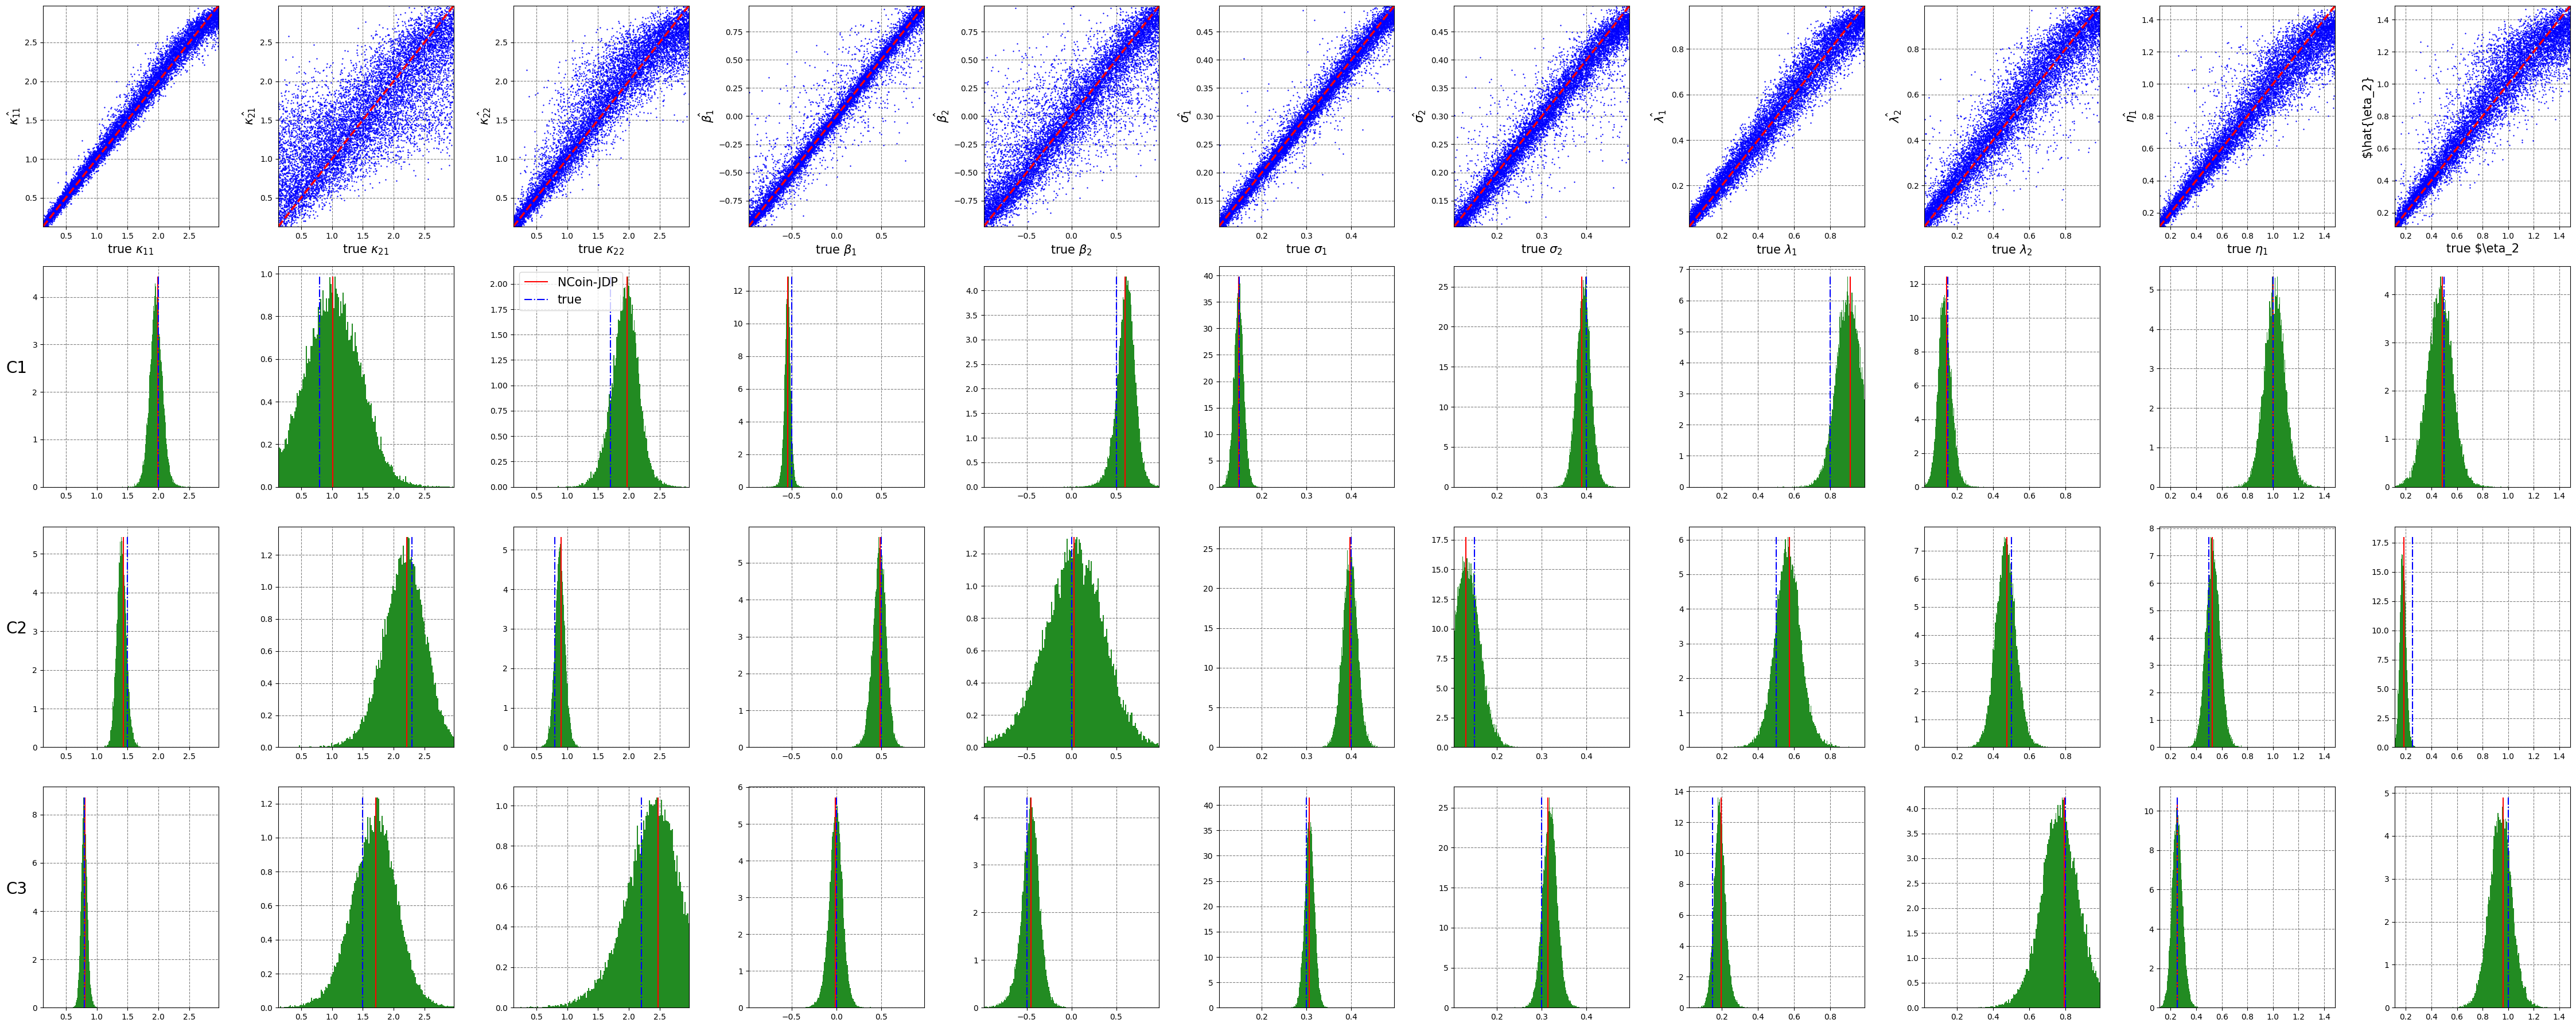

In [22]:
import matplotlib.pyplot as plt

true_name = [r'true $\kappa_{11}$', r'true $\kappa_{21}$', r'true $\kappa_{22}$', 
             r'true $\beta_1$', r'true $\beta_2$',
             r'true $\sigma_1$', r'true $\sigma_2$',
             r'true $\lambda_1$', r'true $\lambda_2$',
             r'true $\eta_1$', r'true $\eta_2']

true_param = np.array(torch.stack([param,param1,param2]))


fig, axs = plt.subplots(4, len(true_name), figsize=(45,18))

est = [net(x0).detach()[0], net(x1).detach()[0], net(x2).detach()[0]]


with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

## Plot for model checking

lim_left = torch.quantile(output,.01, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.99, 0).detach().cpu().numpy()


for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    tmp1 = tmp[:, i]
    axs[0,i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 0.5)
    axs[0,i].set_xlabel(true_name[i], fontsize=15)
    axs[0,i].set_ylabel(esti_name[i], fontsize=15)
    axs[0,i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axs[0,i].set_axisbelow(True)
    axs[0,i].grid(color='gray', linestyle='dashed')
    axs[0,i].set_ylim([lim0, lim1])
    axs[0,i].set_xlim([lim0, lim1])
    #axs[0,0].set_title("Learning Checking", fontsize = 10)

for j in range(3):
    samples_plot = samples[j]
    samples_plot = np.array(samples[j])
    samples_plot = np.concatenate(samples_plot, axis = 1)

    for i in range(len(true_name)):
        lim0 = lim_left[i]
        lim1 = lim_right[i]
        
        y, x, _ = axs[j+1,i].hist(samples_plot[i,:], density=True, bins = 150, color = "forestgreen")
        axs[j+1,i].set_axisbelow(True)
        axs[j+1,i].grid(color='gray', linestyle='dashed')
        axs[j+1,i].set_xlim([lim0, lim1])
    
        axs[j+1,i].vlines(est[j][i], 0, max(y), color = 'red')
        axs[j+1,i].vlines(true_param[j,i], 0, max(y), color = 'blue', linestyle ="dashdot")
        if i == 2 and j == 1:
            axs[j,i].legend(['NCoin-JDP', 'true'], loc = "upper left", fontsize=15) 
axs[1, 0].set_ylabel("C1", fontsize=20, rotation=0, labelpad=20)
axs[2, 0].set_ylabel("C2", fontsize=20, rotation=0, labelpad=20)
axs[3, 0].set_ylabel("C3", fontsize=20, rotation=0, labelpad=20)
fig.tight_layout()
fig.savefig("../JD_plots/BOUJ_infer.pdf")  

In [19]:
# Mean
# Mode
# MAD
# STD
# 95% credible intervals

post_mean = []
post_med = []
post_mode = []
post_mad = []
post_std = []
post_interval = []
for i in range(3): #3 cases
    samples_plot = samples[i]
    samples_plot = np.array(samples[i])
    samples_plot = np.concatenate(samples_plot, axis = 1)

    post_mean_1 = []
    post_med_1 = []
    post_mode_1 = []
    post_mad_1 = []
    post_std_1 = []
    post_interval_1 = []
    
    for j in range(len(true_name)):
        tmp = samples_plot[j,:]
        np.random.seed(1)
        hpd_source = hpd_grid(tmp, 0.1, 5)
        
        post_mean_1.append(np.mean(tmp)) # mean
        post_med_1.append(np.median(tmp)) # mean
        post_mode_1.append(hpd_source[3][0]) # mode
        post_mad_1.append(mad_np(tmp)) # mad
        post_std_1.append(np.std(tmp))
        post_interval_1.append(np.array(hpd_source[0][0])) # interval
    
    post_mean.append(post_mean_1)
    post_med.append(post_med_1)
    post_mode.append(post_mode_1)
    post_mad.append(post_mad_1)
    post_std.append(post_std_1)
    post_interval.append(post_interval_1)

/tmp/ipykernel_23003/1091780546.py:30: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = kde.gaussian_kde(sample)


In [20]:
for i in range(3):
    print("Posterior mean C" + str(i), np.round(post_mean[i], 3))
    print("Posterior median C" + str(i), np.round(post_med[i], 3))
    print("Posterior mode C" + str(i), np.round(post_mode[i],3))
    print("Posterior mad  C" + str(i), np.round(post_mad[i],3))
    print("Posterior std  C" + str(i), np.round(post_std[i],3))
    print("Posterior intvl C" + str(i), np.round(post_interval[i],3))
    print("===========================================================================")


Posterior mean C0 [ 1.963  1.035  1.939 -0.543  0.607  0.149  0.394  0.891  0.134  1.013
  0.465]
Posterior median C0 [ 1.96   1.026  1.946 -0.542  0.612  0.149  0.394  0.895  0.131  1.014
  0.467]
Posterior mode C0 [ 1.954  1.016  1.975 -0.537  0.618  0.151  0.397  0.897  0.124  1.032
  0.471]
Posterior mad  C0 [0.068 0.298 0.138 0.022 0.066 0.007 0.011 0.043 0.024 0.054 0.066]
Posterior std  C0 [0.106 0.426 0.218 0.035 0.107 0.011 0.016 0.061 0.037 0.082 0.1  ]
Posterior intvl C0 [[ 1.789  2.134]
 [ 0.314  1.706]
 [ 1.581  2.295]
 [-0.6   -0.486]
 [ 0.434  0.778]
 [ 0.131  0.167]
 [ 0.366  0.42 ]
 [ 0.806  0.995]
 [ 0.074  0.196]
 [ 0.876  1.146]
 [ 0.298  0.625]]
Posterior mean C1 [1.404 2.16  0.885 0.482 0.023 0.397 0.139 0.565 0.47  0.532 0.178]
Posterior median C1 [1.403 2.177 0.885 0.485 0.034 0.397 0.137 0.565 0.47  0.531 0.177]
Posterior mode C1 [1.404 2.239 0.898 0.483 0.055 0.398 0.131 0.556 0.465 0.52  0.173]
Posterior mad  C1 [0.052 0.225 0.054 0.049 0.22  0.011 0.017 0.04